In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('dialect_results.csv')
del df["hypoparsr"]

red = "#D81B60"
yellow = "#FFC107"
blue = "#1E88E5"
green = "#004D40"
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

In [8]:
import sklearn.metrics
rootpath = "D:\\HPI\\docker\\csv_bert\\experiments\\finetune_dialect\\"
df_dicts = []
dataset_paths = { "dev":"_dev_augmented_complete_results.csv", 
                 "test":"_test_original_results.csv",
                 "weird":"_weird_original_results.csv"}

results_df = {}
for dataset,path in dataset_paths.items():

    clevercs = pd.read_csv(rootpath+"clevercs"+path).fillna("")
    magritte = pd.read_csv(rootpath+"magritte_new"+path).fillna("")
    hybrid = pd.merge(clevercs, magritte, on="filename", suffixes=("_clevercs", "_magritte"))
    hybrid["predicted_delimiter"] = np.where(hybrid["predicted_delimiter_magritte"] == ',', hybrid["predicted_delimiter_magritte"], hybrid["predicted_delimiter_clevercs"])
    hybrid["predicted_quotechar"] = np.where(hybrid["predicted_quotechar_magritte"] == '"', hybrid["predicted_quotechar_magritte"], hybrid["predicted_quotechar_clevercs"])
    hybrid["predicted_escapechar"] = np.where(hybrid["predicted_escapechar_magritte"] == '', hybrid["predicted_escapechar_magritte"], hybrid["predicted_escapechar_clevercs"])

    clevercs = clevercs.merge(magritte[[c for c in magritte.columns if ("target" in c) or c=="filename"]], on="filename")
    def accuracy(df):
        acc = ((df["predicted_delimiter"]== df["target_delimiter"]) &\
        (df["predicted_quotechar"]== df["target_quotechar"]) &\
        (df["predicted_escapechar"]== df["target_escapechar"]))
        return acc.mean()

    avg_type = "weighted"
    for x in ["delimiter", "quotechar", "escapechar"]:
        df_dicts.append(
        {"measure":f"{dataset}_f1_{x}",
        "clevercsv":sklearn.metrics.f1_score(clevercs["predicted_" + x], clevercs["target_" + x], average=avg_type),
        "magritte":sklearn.metrics.f1_score(magritte["predicted_" + x], magritte["target_" + x], average=avg_type),
        "hybrid":sklearn.metrics.f1_score(hybrid["predicted_" + x], hybrid["target_" + x], average=avg_type),} 
        )
    df_dicts.append({"measure":f"{dataset}_accuracy",
                    "clevercsv":accuracy(clevercs),
                    "magritte":accuracy(magritte),
                    "hybrid":accuracy(hybrid),})

    results_df[dataset] = {"clevercsv":clevercs, "magritte":magritte, "hybrid":hybrid}

df = pd.DataFrame(df_dicts)

res = df.set_index("measure")*100
std = res.groupby(lambda x: x.split("_")[0], axis=1).std(numeric_only=True)
res = res.groupby(lambda x: x.split("_")[0], axis=1).mean(numeric_only=True)
res = res.transpose()

res = res.reindex(["clevercsv", "magritte","hybrid"])
display(res)

measure,dev_f1_delimiter,dev_f1_quotechar,dev_f1_escapechar,dev_accuracy,test_f1_delimiter,test_f1_quotechar,test_f1_escapechar,test_accuracy,weird_f1_delimiter,weird_f1_quotechar,weird_f1_escapechar,weird_accuracy
clevercsv,47.398358,56.962886,62.252111,35.710383,97.154981,98.520095,97.945042,93.836247,82.479406,92.370996,94.027651,78.508772
magritte,95.767745,99.054645,89.935167,88.579235,95.083911,92.175261,91.156305,82.980681,87.616022,85.078054,91.793606,74.122807
hybrid,51.655267,59.429576,60.741062,34.808743,97.874446,98.894790,98.220974,94.112236,86.950306,96.661205,95.822544,81.359649


c:\Users\Gerardo\miniconda3\envs\magritte\Lib\site-packages\matplotlib\axes\_axes.py:1103: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
c:\Users\Gerardo\miniconda3\envs\magritte\Lib\site-packages\matplotlib\axes\_axes.py:1104: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])


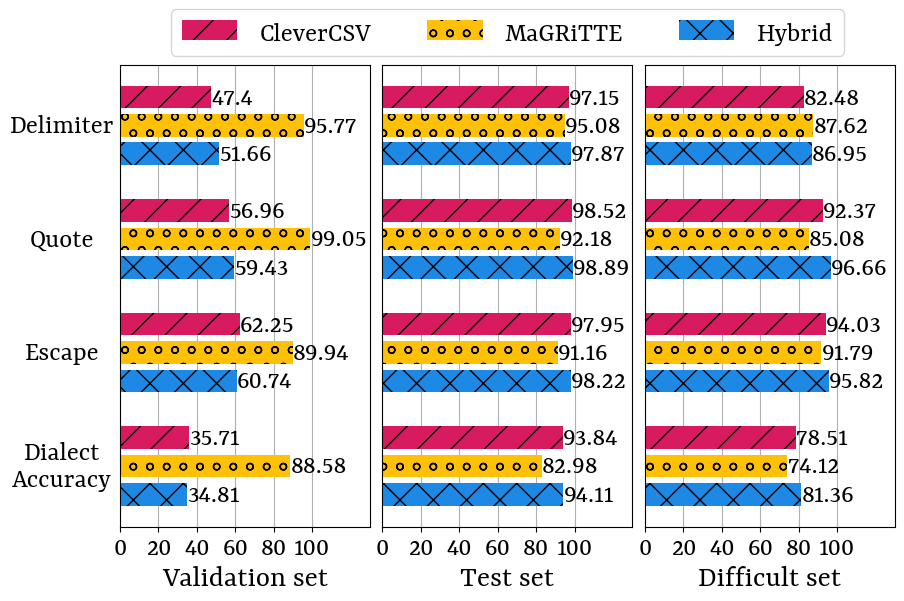

In [9]:
from matplotlib.patches import Patch

plt.rcParams['font.family'] = 'Rasa'
labelsize = 20

colors = [red, yellow, blue]
patterns = ['/', 'o', 'x']

def plot_bar(ax, title, bar1,bar2,bar3,bar4):
  ax.grid(zorder=-10)
  ax.set_axisbelow(True)

  ax.barh([0,1,2],    bar1, color=colors, hatch=patterns, xerr=std["magritte"][bar1.name])
  ax.barh([4,5,6],    bar2, color=colors, hatch=patterns, xerr=std["magritte"][bar2.name])
  ax.barh([8,9,10],   bar3, color=colors, hatch=patterns, xerr=std["magritte"][bar3.name])
  ax.barh([12,13,14], bar4, color=colors, hatch=patterns, xerr=std["magritte"][bar4.name])
  ax.invert_yaxis()

  ypad =0
  xpad=.02
  for j, bar in enumerate([bar1, bar2, bar3, bar4]):
    for i, v in enumerate(bar):
      ax.text(v+xpad, (j*4)+i+ypad, str(round(v, 2)), color='black', size=labelsize, va='center')
  ax.set_yticks([])
  ax.set_xlabel(title, size=labelsize+2);
  ticks = [0, 20, 40, 60, 80, 100]
  ax.set_xticks(ticks=ticks, labels=ticks,size=labelsize);
  ax.set_xlim(0, 130)

fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(nrows=1,ncols=3, wspace=0.05)
axs = gs.subplots(sharey=True)

bars = [res[f"dev_f1_{x}"] for x in ["delimiter", "quotechar", "escapechar"]] + [res["dev_accuracy"]]
plot_bar(axs[0], 'Validation set', *bars)

# stack another plot on the right of the first one reusing the same y axis
bars = [res[f"test_f1_{x}"] for x in ["delimiter", "quotechar", "escapechar"]] + [res["test_accuracy"]]
plot_bar(axs[1], 'Test set', *bars)

bars = [res[f"weird_f1_{x}"] for x in ["delimiter", "quotechar", "escapechar"]] + [res["weird_accuracy"]]
plot_bar(axs[2], 'Difficult set', *bars)

xpoint = -30
axs[0].text(xpoint, 1, 'Delimiter', ha='center', va='center', size=labelsize)
axs[0].text(xpoint, 5, 'Quote', ha='center', va='center', size=labelsize)
axs[0].text(xpoint, 9, 'Escape', ha='center', va='center', size=labelsize)
axs[0].text(xpoint, 13, 'Dialect\nAccuracy', ha='center', va='center', size=labelsize)

custom_bars = [Patch(facecolor=colors[0], hatch=patterns[0]),
               Patch(facecolor=colors[1], hatch=patterns[1]),
               Patch(facecolor=colors[2], hatch=patterns[2]),]

axs[1].legend(handles=custom_bars,
              labels = ["CleverCSV", "MaGRiTTE", "Hybrid"] ,
              loc='center',
              bbox_to_anchor=(0.5, 1.07),
              ncols=3,
              fontsize=labelsize)

plt.savefig('dialect_results.png', dpi=300, bbox_inches='tight')